In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report


measurements = pd.read_csv('exercise_data.csv')
measurements.head()

,timestampUtc,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,measurementId,activity,repetitions
0,2021-05-19 19:32:28.910,-0.988300,-0.284200,0.008800,-0.988300,-0.284200,0.008800,1,Walking,5
1,2021-05-19 19:32:28.920,-0.986478,-0.276122,0.007411,-0.986478,-0.276122,0.007411,1,Walking,5
2,2021-05-19 19:32:28.930,-0.984656,-0.268044,0.006022,-0.984656,-0.268044,0.006022,1,Walking,5
3,2021-05-19 19:32:28.940,-0.982833,-0.259967,0.004633,-0.982833,-0.259967,0.004633,1,Walking,5
4,2021-05-19 19:32:28.950,-0.981011,-0.251889,0.003244,-0.981011,-0.251889,0.003244,1,Walking,5


In [2]:
# Taking every row from  each measurement and dividing it by its repetitions value
# f.e. -> measurementId = 1 got 41 repetitions, I'll divide this set into 41 parts

# Saving all measurementId's and repetitions that are in our .csv file
measurement_list = []
repetitions_list = []

measurements = measurements.drop('timestampUtc', axis = 1)

for index, row in measurements.iterrows():
    if measurement_list.count(int(row['measurementId']))==0:
        measurement_list.append(int(row['measurementId']))
        repetitions_list.append(int(row['repetitions']))


print(measurement_list)
print(repetitions_list)
print(len(measurement_list)==len(repetitions_list))

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]
[5, 10, 2, 8, 10, 2, 10, 3, 15, 4, 1, 10, 15, 10, 10, 5, 10, 10, 5, 5, 3, 4, 2, 3, 5, 2, 7, 1, 12, 3, 2, 1, 7, 5, 3, 3, 3, 3, 3, 3, 5, 5, 3, 1, 1, 1, 1, 5, 5, 1, 1, 40, 40, 15, 3, 5, 1, 1, 2, 3, 10, 7, 1, 2, 5, 5, 5, 5, 5, 5, 5, 7, 4, 4, 2, 2, 4, 3, 2, 15, 12, 6, 8, 6, 8, 4, 10, 4, 1, 1, 1, 1, 1]
True


In [3]:
amount = np.ones(len(measurement_list)+1, dtype=int)
measure_temp = [] # checking if we already counted for this measurement
iter = 0

for index, row in measurements.iterrows():
    if measure_temp.count(int(row['measurementId']))==0:
        iter += 1
        measure_temp.append(int(row['measurementId']))
    if measure_temp.count(int(row['measurementId']))>0:
        amount[iter] += 1

print(amount)

amount = np.delete(amount, 0, 0)
amount = amount.tolist()

[    1  6646  1572   504  1567   806   505  1337   241  1069   811   515
  3719  2122  2122  2909  1051  1568  1838  1582  1852  1052  1842  1050
  1315  1312   502  1573  3971  2923   780   501   236  1581  1298  1302
  1041   776   772   771   771  1298  1303  1032 15337 16999  8239  7087
  5876   783   510   515  2634  2629  1074   509  1303   241   241   275
   538  1567  1035   275   241   807   520   771   772  5896  1307  1312
  1581  1316  1050   515   785   775   780   519  3454  2652  1316  1851
  1316  2919  1051  1582   776  7715  5582  5577  2644  3449]


In [4]:
print(len(amount)==len(measurement_list)==len(repetitions_list))

True


In [5]:
# Dividing all measurements for each repetition (amount[x]/repetitions_list[x] - amount of rows for one repetition for measurement_list[x])
# f.e. - amount[0]/repetitions_list[0] would be an amount of rows for one push-up (rounded) (first object of measurement_list[0] class, which is push-up)
# and then next amount[0]/repetitions_list[0] for next object of this class and this will be repeated for repetition_list[0] times

classes = []
for index, row in measurements.iterrows():
    if classes.count(row['activity'])==0:
        classes.append(row['activity'])

In [6]:
print(classes)

['Walking', 'Push ups', 'Squats', 'Jump front & back', 'Frontal elevation of arms']


In [26]:
measurements = measurements.drop('measurementId', axis = 1)
y = measurements['activity']
X = measurements.drop('activity', axis = 1)

In [27]:
# AKTUALNE - bez podziału na powtórzenia
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

In [28]:
print(y_train.value_counts())
print('*'*50)
print(y_test.value_counts())

Walking                      69385
Squats                       24378
Frontal elevation of arms    14108
Push ups                     13560
Jump front & back            12789
Name: activity, dtype: int64
**************************************************
Walking                      29711
Squats                       10394
Frontal elevation of arms     6096
Push ups                      5756
Jump front & back             5566
Name: activity, dtype: int64


In [29]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [30]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


'''
PARAMS:
sol - solver (‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’)
max - max iterations
jobs - number of CPU cores used during the cross-validation loop
'''
def LogReg(sol = 'saga', max = 2000, jobs = 3):
    model = LogisticRegression(solver=sol, max_iter=max, n_jobs=jobs)
    model.fit(X_train, y_train)
    name = 'LogReg: {} solver, {} maximum number of iterations, {} CPU cores used'.format(sol, max, jobs)
    return model, name

def GausNB():
    model = GaussianNB()
    model.fit(X_train, y_train)
    name = 'Gaussian Naive Bayes'
    return model, name

def BernNB():
    model = BernoulliNB()
    model.fit(X_train, y_train)
    name = 'Bernoulli Naive Bayes'
    return model, name


'''
PARAMS:
crit - the function to measure the quality of a split ('gini', 'entropy')
depth - the maximum depth of the tree
split - the minimum number of samples required to split an internal node
leaf - the minimum number of samples required to be at a leaf node
feat - the number of features to consider when looking for the best split (int, float or {'auto', 'sqrt', 'log2'})
'''
def DecTree(crit = "entropy", depth = None, split = 2, leaf = 1, feat = "sqrt"):
    model = DecisionTreeClassifier(criterion = crit, max_depth = depth, min_samples_split = split, min_samples_leaf = leaf, max_features = feat)
    model.fit(X_train, y_train)
    name = "Decision Tree Classifier: {} as criterion, maximum depth: {}, minimum number of samples to split: {}, \nminimum number of samples required to be a leaf: {}, maximum features: {}".format(crit, depth, split, leaf, feat)
    return model, name
    
    

In [31]:
MODELS = []
NAMES = []
#model1 = BernoulliNB(binarize = 'float')

model_LogReg, name_LogReg = LogReg()
MODELS.append(model_LogReg)
NAMES.append(name_LogReg)

model_GausNB, name_GausNB = GausNB()
MODELS.append(model_GausNB)
NAMES.append(name_GausNB)

model_BernNB, name_BernNB = BernNB()
MODELS.append(model_BernNB)
NAMES.append(name_BernNB)

model_DecTree, name_DecTree = DecTree()
MODELS.append(model_DecTree)
NAMES.append(name_DecTree)



In [32]:

model_DecTree2, name_DecTree2 = DecTree("gini", 20, 5, 5, "auto")
MODELS.append(model_DecTree2)
NAMES.append(name_DecTree2)

model_DecTree3, name_DecTree3 = DecTree("gini", 5, 2, 2, "auto")
MODELS.append(model_DecTree3)
NAMES.append(name_DecTree3)

model_DecTree4, name_DecTree4 = DecTree("entropy", 5, 2, 2, "auto")
MODELS.append(model_DecTree4)
NAMES.append(name_DecTree4)

In [33]:
iter_names = 0

for model in MODELS:
    acc = model.score(X_test, y_test)
    print(NAMES[iter_names])
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    iter_names += 1

LogReg: saga solver, 2000 maximum number of iterations, 3 CPU cores used
Test Accuracy: 62.96%
Gaussian Naive Bayes
Test Accuracy: 64.64%
Bernoulli Naive Bayes
Test Accuracy: 62.05%
Decision Tree Classifier: entropy as criterion, maximum depth: None, minimum number of samples to split: 2, 
minimum number of samples required to be a leaf: 1, maximum features: sqrt
Test Accuracy: 94.18%
Decision Tree Classifier: gini as criterion, maximum depth: 20, minimum number of samples to split: 5, 
minimum number of samples required to be a leaf: 5, maximum features: auto
Test Accuracy: 93.87%
Decision Tree Classifier: gini as criterion, maximum depth: 5, minimum number of samples to split: 2, 
minimum number of samples required to be a leaf: 2, maximum features: auto
Test Accuracy: 80.45%
Decision Tree Classifier: entropy as criterion, maximum depth: 5, minimum number of samples to split: 2, 
minimum number of samples required to be a leaf: 2, maximum features: auto
Test Accuracy: 76.38%


In [34]:
import seaborn as sns
def draw_confusion_matrix(model, name):

    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    clr = classification_report(y_test, y_pred, labels=classes, target_names=classes)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=90)
    plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for "+ name + " model")
    plt.show()

    print("Classification Report:\n----------------------\n", clr)


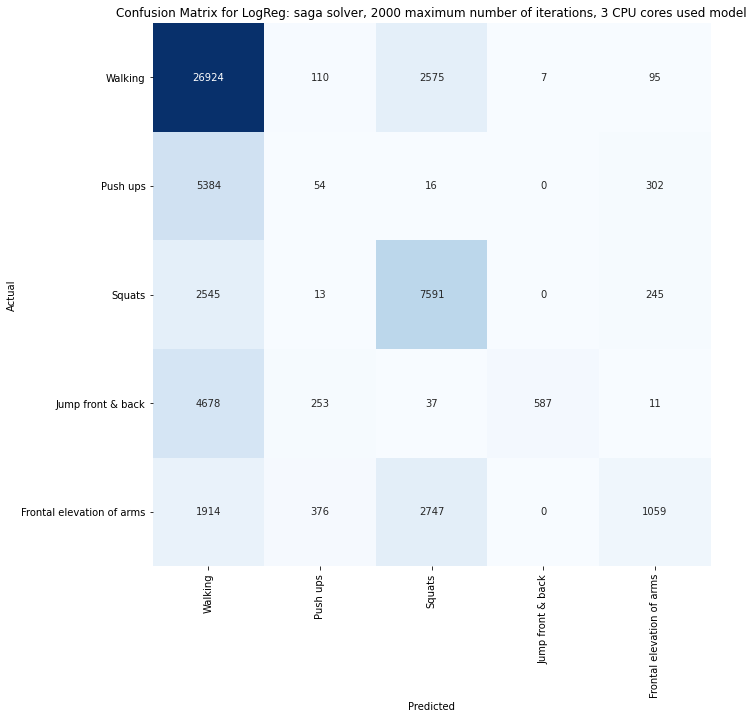

Classification Report:
----------------------
                            precision    recall  f1-score   support

                  Walking       0.65      0.91      0.76     29711
                 Push ups       0.07      0.01      0.02      5756
                   Squats       0.59      0.73      0.65     10394
        Jump front & back       0.99      0.11      0.19      5566
Frontal elevation of arms       0.62      0.17      0.27      6096

                 accuracy                           0.63     57523
                macro avg       0.58      0.39      0.38     57523
             weighted avg       0.61      0.63      0.56     57523



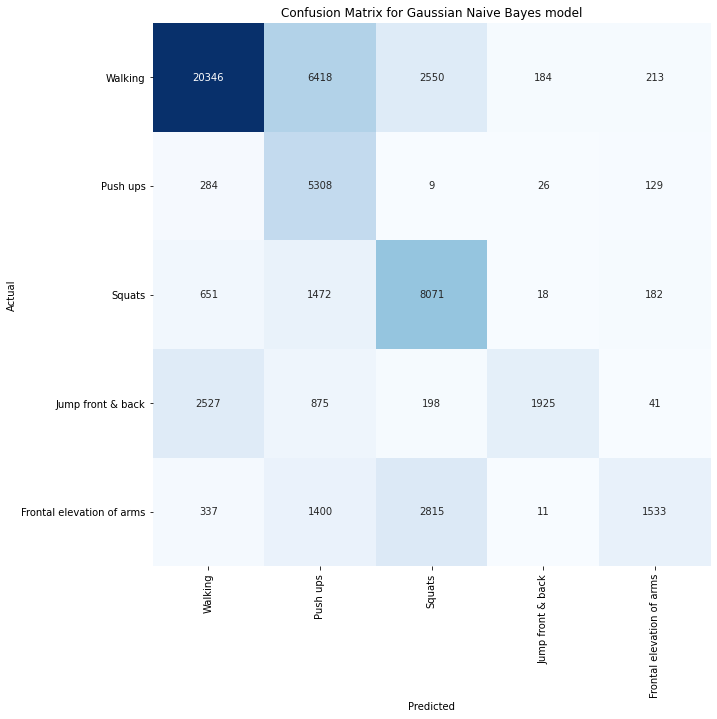

Classification Report:
----------------------
                            precision    recall  f1-score   support

                  Walking       0.84      0.68      0.76     29711
                 Push ups       0.34      0.92      0.50      5756
                   Squats       0.59      0.78      0.67     10394
        Jump front & back       0.89      0.35      0.50      5566
Frontal elevation of arms       0.73      0.25      0.37      6096

                 accuracy                           0.65     57523
                macro avg       0.68      0.60      0.56     57523
             weighted avg       0.74      0.65      0.65     57523

C:\Users\Gmerek\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:

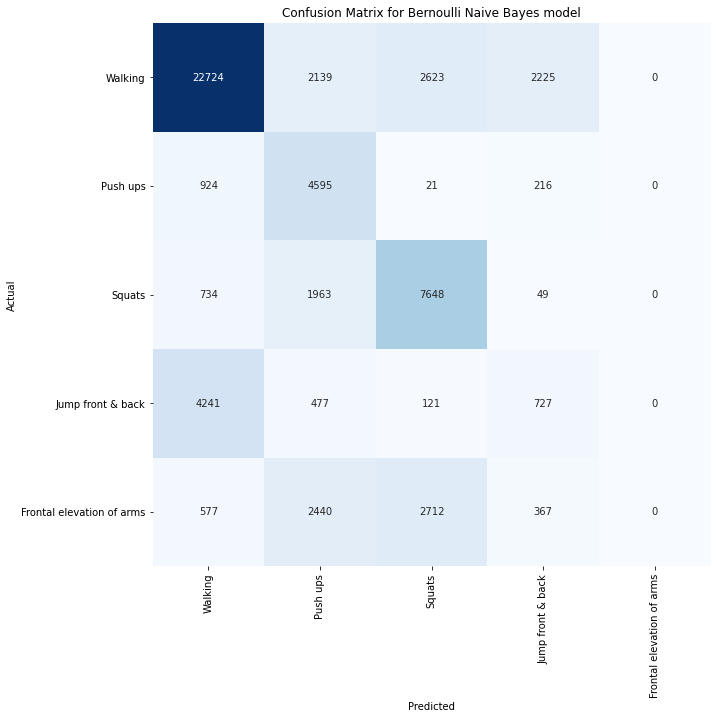

Classification Report:
----------------------
                            precision    recall  f1-score   support

                  Walking       0.78      0.76      0.77     29711
                 Push ups       0.40      0.80      0.53      5756
                   Squats       0.58      0.74      0.65     10394
        Jump front & back       0.20      0.13      0.16      5566
Frontal elevation of arms       0.00      0.00      0.00      6096

                 accuracy                           0.62     57523
                macro avg       0.39      0.49      0.42     57523
             weighted avg       0.57      0.62      0.58     57523



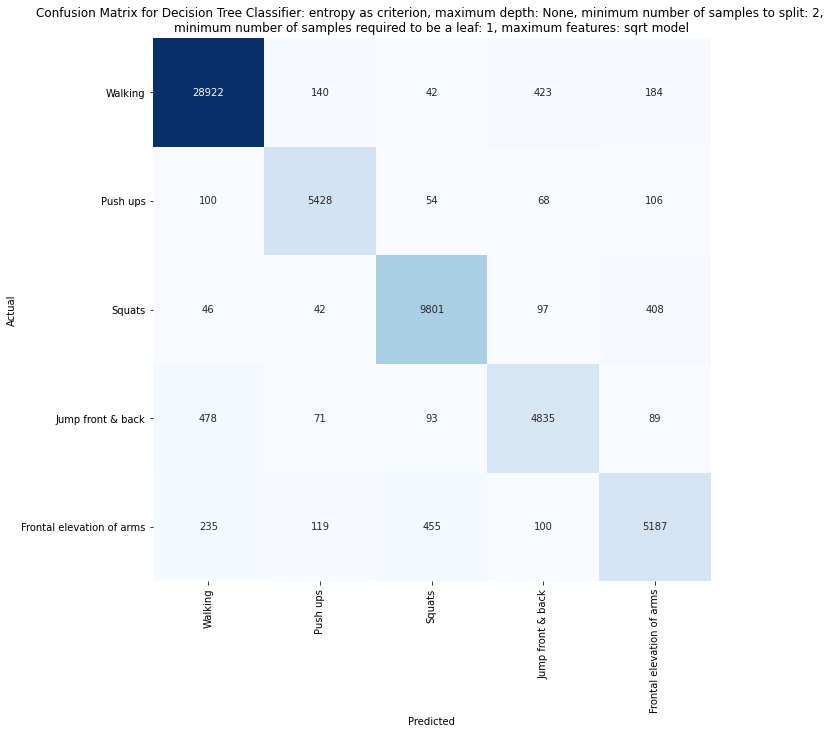

Classification Report:
----------------------
                            precision    recall  f1-score   support

                  Walking       0.97      0.97      0.97     29711
                 Push ups       0.94      0.94      0.94      5756
                   Squats       0.94      0.94      0.94     10394
        Jump front & back       0.88      0.87      0.87      5566
Frontal elevation of arms       0.87      0.85      0.86      6096

                 accuracy                           0.94     57523
                macro avg       0.92      0.92      0.92     57523
             weighted avg       0.94      0.94      0.94     57523



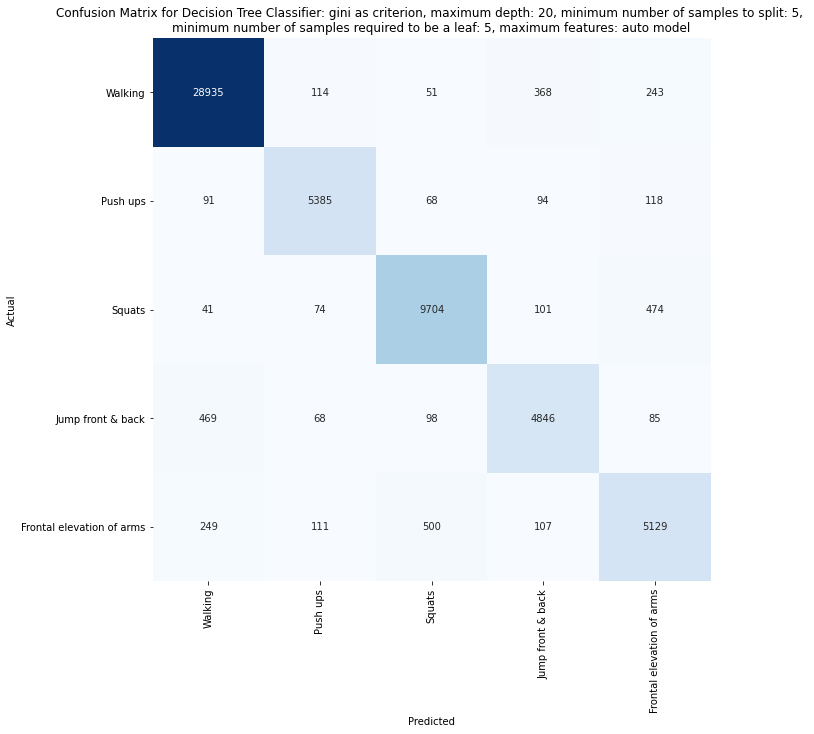

Classification Report:
----------------------
                            precision    recall  f1-score   support

                  Walking       0.97      0.97      0.97     29711
                 Push ups       0.94      0.94      0.94      5756
                   Squats       0.93      0.93      0.93     10394
        Jump front & back       0.88      0.87      0.87      5566
Frontal elevation of arms       0.85      0.84      0.84      6096

                 accuracy                           0.94     57523
                macro avg       0.91      0.91      0.91     57523
             weighted avg       0.94      0.94      0.94     57523



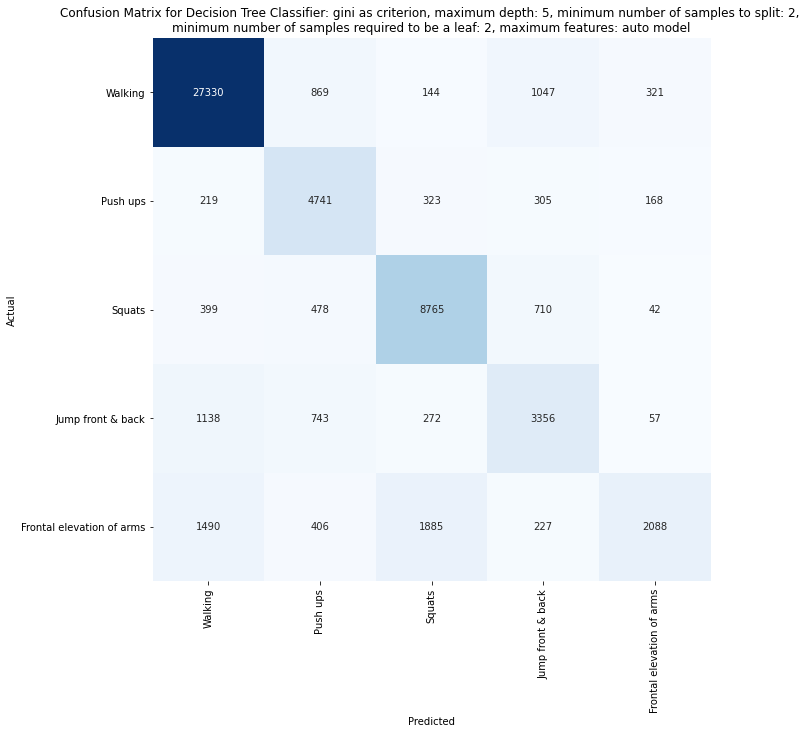

Classification Report:
----------------------
                            precision    recall  f1-score   support

                  Walking       0.89      0.92      0.91     29711
                 Push ups       0.66      0.82      0.73      5756
                   Squats       0.77      0.84      0.80     10394
        Jump front & back       0.59      0.60      0.60      5566
Frontal elevation of arms       0.78      0.34      0.48      6096

                 accuracy                           0.80     57523
                macro avg       0.74      0.71      0.70     57523
             weighted avg       0.81      0.80      0.80     57523



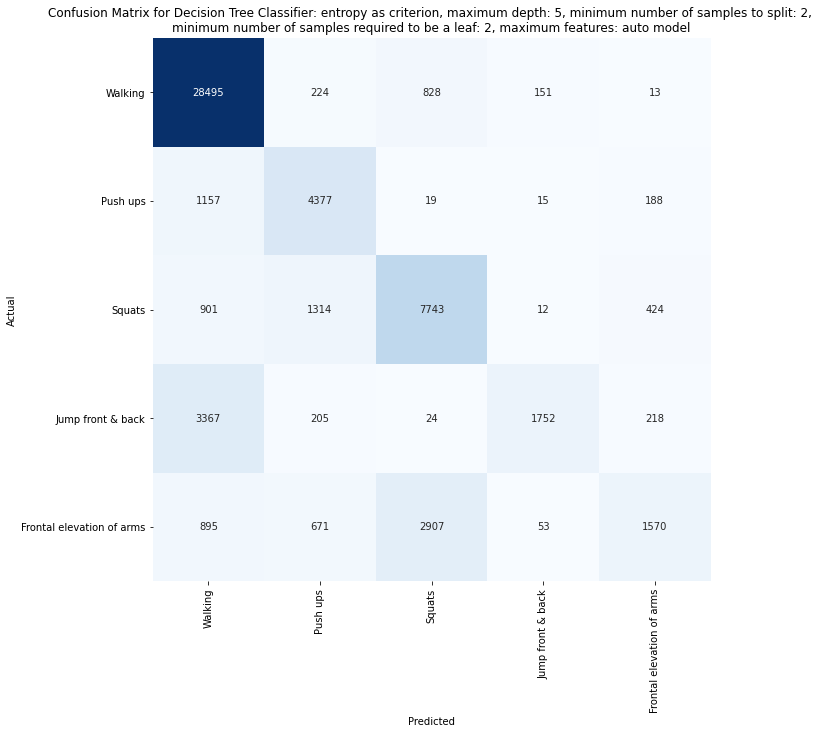

Classification Report:
----------------------
                            precision    recall  f1-score   support

                  Walking       0.82      0.96      0.88     29711
                 Push ups       0.64      0.76      0.70      5756
                   Squats       0.67      0.74      0.71     10394
        Jump front & back       0.88      0.31      0.46      5566
Frontal elevation of arms       0.65      0.26      0.37      6096

                 accuracy                           0.76     57523
                macro avg       0.73      0.61      0.62     57523
             weighted avg       0.76      0.76      0.74     57523



In [35]:
i = 0
for model in MODELS:
    draw_confusion_matrix(model, NAMES[i])
    i+=1


In [37]:
# Saving models
import joblib
i = 1
filenames = []

# Deleting all special "things" in names
#for name in NAMES:
#    fname = name
#    " ".join(fname.split())
#    fname.replace(" ", "")
#    fname.replace("\n", "")
#    filenames.append(fname)

# Wybaczcie, nie mam czasu zbytnio teraz więc będzie obejście, modele po prostu będą numerowane
# Nie wiem czemu powyższy kod nie działa i nie usuwa znaków specjalnych

for model in MODELS:
    #filename = 'models/' + filenames[i] + '.sav'
    #joblib.dump(model, filename)
    joblib.dump(model, 'models/' + str(i)+'.sav')
    i += 1

# Loading : joblib.load(filename)

In [19]:
print(filenames)

[]
